# RNN / LSTM / GRU

## setup

In [1]:
from datetime import datetime
from torchvision import datasets, transforms
import os
import wandb
import requests
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm

device = 'cuda' if t.cuda.is_available() else 'cpu'

## utils

In [2]:
# download alice in wonderland
path = f'data/alice.txt'
if not os.path.exists(path):
    url = 'https://www.gutenberg.org/cache/epub/11/pg11.txt'
    book = requests.get(url).content
    book = book.decode('ascii', 'ignore')
    with open(path, 'w') as file:
        file.write(book)

with open(path, 'r') as file:
    book = file.read()
assert (start := book.find('\nDown the Rabbit-Hole')) != -1
assert (end := book.find('THE END')) != -1
book = book[start: end]

In [3]:
vocab = set(book)
d_vocab = len(vocab)
d_hidden = 100
d_batch = 10000
atoi = {a: i for i, a in enumerate(sorted(vocab))}
itoa = {i: a for a, i in atoi.items()}

In [4]:
def to_dataloader(text, seq_len=25, batch_size=d_batch):
    # use a chunk with both x and y overlapping to share the same memory
    # also use seq_len // 2 to make more training data
    chunks = [text[i:i+seq_len+1] for i in range(0, len(text)-seq_len-1, seq_len // 2)]
    chunks = t.tensor([[atoi[a] for a in s] for s in chunks])
    x = chunks[:, :-1]
    y = chunks[:, 1:]
    assert x.untyped_storage().data_ptr() == y.untyped_storage().data_ptr()
    dataset = TensorDataset(x, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

dataloader = to_dataloader(book, 50)

In [5]:
def train(model, dataloader, epochs=2001, opt=None, lr=3e-4, filename='', wnb=True):
    model.train()
    model = model.to(device)
    if opt is None: opt = t.optim.AdamW(model.parameters(), lr=lr)
    if wnb: wandb.init(project=filename)
    for epoch in tqdm(range(epochs)):
        for xs, ys in dataloader:
            with t.autocast(device_type=device, dtype=t.bfloat16):
                out = model(xs.to(device))
                loss = F.cross_entropy(out.permute(0, 2, 1), ys.to(device))
            opt.zero_grad()
            loss.backward()
            opt.step()
        if wnb:
            wandb.log({'loss': loss.item()})
        if wnb and epoch % 100 == 0:
            wandb.log({'sample_html': wandb.Html(f'<p>{model.sample(d_sample=200)}</p>')})
        if epoch % 50 == 0:
            print(f'loss={loss.item():.4f}')
        if epoch % 1000 == 0:
            print(model.sample())
        if epoch % 1000 == 0:
            t.save(model.state_dict(), f'weights/{filename}_{datetime.now().strftime("%Y-%m-%d_%Hh%M")}.pt')
    if wnb: wandb.finish()

## Recurrent Neural Networks (RNN)

### model

In [6]:
class RNN(nn.Module):
    def __init__(self, d_in, d_hidden):
        super().__init__()
        self.d_hidden = d_hidden
        self.i2h = nn.Linear(d_in, d_hidden)
        self.h2h = nn.Linear(d_hidden, d_hidden)

    def forward(self, xs, memory=None, return_memory=False):
        # xs: (batch, d_context, d_in)
        batch, d_context, _ = xs.shape
        outs = []
        if memory is None: memory = t.zeros(batch, self.d_hidden, device=xs.device)
        for i in range(d_context):
            x = xs[:, i]
            memory = F.tanh(self.i2h(x) + self.h2h(memory))
            outs.append(memory)
        return t.stack(outs, dim=1)

class AliceRNN(nn.Module):
    def __init__(self, d_vocab, d_hidden):
        super().__init__()
        self.d_hidden = d_hidden
        self.embed = nn.Embedding(d_vocab, d_hidden)
        self.rnn = RNN(d_hidden, d_hidden)
        self.unembed = nn.Linear(d_hidden, d_vocab)
        self.unembed.weight = self.embed.weight

    def forward(self, xs):
        xs = self.embed(xs)
        out = self.rnn(xs)
        return self.unembed(out)

    @t.no_grad()
    def sample(self, text='A', d_sample=100):
        x = t.tensor([[atoi[c] for c in text]]).to(device)
        h_prev = t.zeros(1, self.d_hidden, device=x.device)
        while len(text) < d_sample:
            x = self.embed(x)
            h_prev = self.rnn(x, h_prev)[:, -1]
            out = self.unembed(h_prev)
            probs = out.softmax(-1)
            next_sample = t.multinomial(probs, num_samples=1)
            text += itoa[next_sample[0].item()]
            x = next_sample
        return text

rnn = AliceRNN(d_vocab, d_hidden).to(device)
rnn.sample()

'AfIUNvUw;T_a-]s!UE_augi);TiGgT]s!yIcLchhhyIcLy)C.cLcLzjUNKC.S:]sNvUgi);TiGiGgiGT]s!yIcLchF_*KC.cL-Wv'

### train

In [31]:
# train(rnn, dataloader, filename='rnn')

In [32]:
# print(rnn.sample(d_sample=2000))

## Long Short-Term Memory (LSTM)

### model

In [7]:
class LSTMCell(nn.Module):
    def __init__(self, d_in, d_hidden):
        super().__init__()
        self.W_f = nn.Linear(d_in + d_hidden, d_hidden)  # forget gate
        self.W_i = nn.Linear(d_in + d_hidden, d_hidden)  # input gate
        self.W_c = nn.Linear(d_in + d_hidden, d_hidden)  # cell state update
        self.W_o = nn.Linear(d_in + d_hidden, d_hidden)  # output gate

    def forward(self, x, h_prev, c_prev):
        x = t.cat((x, h_prev), dim=1)
        # handle long-term memory `C`
        f_gate = t.sigmoid(self.W_f(x))
        i_gate = t.sigmoid(self.W_i(x))
        c_update = t.tanh(self.W_c(x))
        c_prev = f_gate * c_prev + i_gate * c_update
        # handle short-term memory `h`
        o_gate = t.sigmoid(self.W_o(x))
        h_prev = o_gate * t.tanh(c_prev)
        return h_prev, c_prev

class LSTM(nn.Module):
    def __init__(self, d_in, d_hidden):
        super().__init__()
        self.d_hidden = d_hidden
        self.lstm_cell = LSTMCell(d_in, d_hidden)

    def forward(self, xs, h_prev=None, c_prev=None):
        # xs: (batch, d_context, d_in)
        batch, d_context, _ = xs.shape
        hs, cs = [], []
        if h_prev is None: h_prev = t.zeros(batch, self.d_hidden, device=xs.device)
        if c_prev is None: c_prev = t.zeros(batch, self.d_hidden, device=xs.device)
        for i in range(d_context):
            x = xs[:, i]
            h_prev, c_prev = self.lstm_cell(x, h_prev, c_prev)
            hs.append(h_prev)
            cs.append(c_prev)
        return t.stack(hs, dim=1), t.stack(cs, dim=1)

class AliceLSTM(nn.Module):
    def __init__(self, d_vocab, d_hidden):
        super().__init__()
        self.d_hidden = d_hidden
        self.embed = nn.Embedding(d_vocab, d_hidden)
        self.lstm = LSTM(d_hidden, d_hidden)
        self.unembed = nn.Linear(d_hidden, d_vocab)
        self.unembed.weight = self.embed.weight

    def forward(self, xs):
        xs = self.embed(xs)
        out, _ = self.lstm(xs)
        return self.unembed(out)

    @t.no_grad()
    def sample(self, text='A', d_sample=100):
        x = t.tensor([[atoi[c] for c in text]]).to(device)
        h_prev = t.zeros(1, self.d_hidden, device=x.device)
        c_prev = t.zeros(1, self.d_hidden, device=x.device)
        while len(text) < d_sample:
            x = self.embed(x)
            h_prev, c_prev = self.lstm(x, h_prev, c_prev)
            h_prev, c_prev = h_prev[:, -1], c_prev[:, -1]
            out = self.unembed(h_prev)
            probs = out.softmax(-1)
            next_sample = t.multinomial(probs, num_samples=1)
            text += itoa[next_sample[0].item()]
            x = next_sample
        return text

lstm = AliceLSTM(d_vocab, d_hidden).to(device)
lstm.sample()

'ABQhI! \nEEbWsnWmJA_wG_ncMVdEOm.KSnZYk[t*pDHa-Eo_,;kITk,-\nduZRh!SvsJuIkvvJZR\nFHUudHFZBUi[mHq.z*u_IcYo'

### train

In [34]:
# train(lstm, dataloader, filename='lstm')

In [35]:
# print(lstm.sample(d_sample=2000))

## Gated Recurrent Unit (GRU)

### model

In [8]:
class GRUCell(nn.Module):
    def __init__(self, d_in, d_hidden):
        super().__init__()
        self.W_r = nn.Linear(d_in + d_hidden, d_hidden)  # reset gate
        self.W_z = nn.Linear(d_in + d_hidden, d_hidden)  # update gate
        self.W_h = nn.Linear(d_in + d_hidden, d_hidden)  # hidden state update

    def forward(self, x, h_prev):
        cat = t.cat((x, h_prev), dim=1)
        r_gate = t.sigmoid(self.W_r(cat))
        z_gate = t.sigmoid(self.W_z(cat))
        h_candidate = t.tanh(self.W_h(t.cat((x, r_gate * h_prev), dim=1)))
        h_prev = (1 - z_gate) * h_prev + z_gate * h_candidate
        return h_prev

class GRU(nn.Module):
    def __init__(self, d_in, d_hidden):
        super().__init__()
        self.d_hidden = d_hidden
        self.gru_cell = GRUCell(d_in, d_hidden)

    def forward(self, xs, h_prev=None):
        # xs: (batch, d_context, d_in)
        batch, d_context, _ = xs.shape
        outs = []
        if h_prev is None: h_prev = t.zeros(batch, self.d_hidden, device=xs.device)
        for i in range(d_context):
            x = xs[:, i]
            h_prev = self.gru_cell(x, h_prev)
            outs.append(h_prev)
        return t.stack(outs, dim=1)

class AliceGRU(nn.Module):
    def __init__(self, d_vocab, d_hidden):
        super().__init__()
        self.d_hidden = d_hidden
        self.embed = nn.Embedding(d_vocab, d_hidden)
        self.gru = GRU(d_hidden, d_hidden)
        self.unembed = nn.Linear(d_hidden, d_vocab)
        self.unembed.weight = self.embed.weight

    def forward(self, xs):
        xs = self.embed(xs)
        out = self.gru(xs)
        return self.unembed(out)

    @t.no_grad()
    def sample(self, text='A', d_sample=100):
        x = t.tensor([[atoi[c] for c in text]], device=device)
        h_prev = t.zeros(1, self.d_hidden, device=device)
        while len(text) < d_sample:
            x = self.embed(x)
            h_prev = self.gru(x, h_prev)[:, -1]
            out = self.unembed(h_prev)
            probs = out.softmax(-1)
            next_sample = t.multinomial(probs, num_samples=1)
            text += itoa[next_sample[0].item()]
            x = next_sample
        return text

gru = AliceGRU(d_vocab, d_hidden).to(device)
gru.sample()

'AEiDlNR)uEm,;ORm__aGGpep-[b\nw)TKeUyAOo]]s\ns]sTqB*DDLPvSGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGhhhcguKmejwzr'

### train

In [37]:
# train(gru, dataloader, filename='gru')

In [38]:
# print(gru.sample(d_sample=2000))

## Stacked LSTM

### model

In [9]:
class StackedLSTM(nn.Module):
    def __init__(self, d_in, d_hidden, d_layers):
        super().__init__()
        self.d_hidden = d_hidden
        self.d_layers = d_layers
        self.lstm_cells = nn.ModuleList([LSTMCell(d_in if l == 0 else d_hidden, d_hidden) for l in range(d_layers)])

    def forward(self, xs, h_prev=None, c_prev=None):
        # xs: (batch, d_context, d_in)
        batch, d_context, _ = xs.shape
        outs = []
        if h_prev is None: h_prev = t.zeros(self.d_layers, batch, self.d_hidden, device=xs.device)
        if c_prev is None: c_prev = t.zeros(self.d_layers, batch, self.d_hidden, device=xs.device)
        for i in range(d_context):
            x = xs[:, i]
            h_next, c_next = [], []
            for lstm_cell, h, c in zip(self.lstm_cells, h_prev, c_prev):
                h, c = lstm_cell(x, h, c)
                h_next.append(h)
                c_next.append(c)
                x = h
            outs.append(h)
            h_prev = t.stack(h_next)
            c_prev = t.stack(c_next)
        return t.stack(outs, dim=1), h_prev, c_prev

class AliceStackedLSTM(nn.Module):
    def __init__(self, d_vocab, d_hidden, d_layers):
        super().__init__()
        self.d_hidden = d_hidden
        self.d_layers = d_layers
        self.embed = nn.Embedding(d_vocab, d_hidden)
        self.stacked_lstm = StackedLSTM(d_hidden, d_hidden, d_layers)
        self.unembed = nn.Linear(d_hidden, d_vocab)
        self.unembed.weight = self.embed.weight

    def forward(self, xs):
        xs = self.embed(xs)
        out, _, _ = self.stacked_lstm(xs)
        return self.unembed(out)

    @t.no_grad()
    def sample(self, text='A', d_sample=100, topk=5):
        x = t.tensor([[atoi[c] for c in text]], device=device)
        h_prev = t.zeros(self.d_layers, 1, self.d_hidden, device=device)
        c_prev = t.zeros(self.d_layers, 1, self.d_hidden, device=device)
        while len(text) < d_sample:
            x = self.embed(x)
            out, h_prev, c_prev = self.stacked_lstm(x, h_prev, c_prev)
            out = self.unembed(out[:, -1])
            probs = out.softmax(-1)
            # prevent weird behaviors by sampling only from the topk tokens
            topk_probs, topk_indices = t.topk(probs, topk, dim=-1)
            idx = t.multinomial(topk_probs, 1)
            next_sample = t.gather(topk_indices, -1, idx)
            text += itoa[next_sample[0].item()]
            x = next_sample
        return text

stacked_lstm = AliceStackedLSTM(d_vocab, d_hidden, 2).to(device)
stacked_lstm.sample()

'AiHu-ui--JuiuJuiqu-i-uiJuui-iJJkuk-A-AJiuussIuTTY??u?Y?FXXMN-i--iuusiITuJTA?AAiusiJsITu?iu?-TTuusLIY'

### train

In [ ]:
train(stacked_lstm, dataloader, filename='stacked_lstm_2_layers', epochs=10000)

In [53]:
# t.save(stacked_lstm.state_dict(), f'weights/stacked_lstm_2_{datetime.now().strftime("%Y-%m-%d_%Hh%M")}.pt')

In [28]:
# t.save(atoi, 'weights/atoi.pt')
# t.save(itoa, 'weights/itoa.pt')

In [10]:
# atoi = t.load('weights/atoi.pt')
# itoa = t.load('weights/itoa.pt')
# stacked_lstm.load_state_dict(t.load('weights/stacked_lstm_2_2024-06-11_16h58.pt'))

<All keys matched successfully>

In [11]:
print(stacked_lstm.sample(d_sample=2000))

Alice heard the Rabbit just lonsea used to Alice: expectetly rawich, who tespecleeze (sseepil
the whole parme, when it severpecticuresant schop again!? Alice very sleater afraid hils at last, they dont_ remarked _you, said the King, and went.

Of Mock Turtle went on, you see, a dog growls when
you undowst to
tum:
ng
her. Ive me never was begining in them, came, Alice), and she said to the Queen.

I havent to look body leaves, said the Mujcsure till the Panther or at wherthing
toly ispe, (whe was in Billpot it was very uncomfortable for them with stupy.
Ar then,
sir I know I do that? sighed the White Rabbit was nerroo of neare voice, a


Herald, before, Such it toys that him in
where sharp
little conqueers off anoty fire! I draw? Onexw clossion, and this so, savasted, afterwallyed of eavilat in frightened out whise. And theres my
book, out here, all tood taken the voice otherh!

IIdioutinn in right-lean child: but it pocket? Wher is arm all many miseences, and she trying to idea was in 

## visualize

### lib

In [12]:
from io import BytesIO
from IPython.display import display, HTML
import base64
import json
import matplotlib.pyplot as plt
import string
import random

In [13]:
def assert_sanity_check(model):
    ''' Check that computing the embedding by hand is equivalent to using the nn.Embedding '''
    t_vocab = t.arange(d_vocab, device=device)
    manual = F.one_hot(t_vocab, num_classes=d_vocab).float() @ model.embed.weight
    auto = model.embed(t_vocab)
    assert t.allclose(manual, auto)

def saliency(self, text):
    assert_sanity_check(self)
    token_ids = [atoi[c] for c in text]
    xs = F.one_hot(t.tensor([token_ids], device=device), num_classes=d_vocab).float()
    xs.requires_grad = True    
    embeds = xs @ self.embed.weight
    outs, _, _ = self.stacked_lstm(embeds)
    saliencies = [()] # nothing caused the first token
    for idx, (out, token_id) in enumerate(zip(outs[0], token_ids[1:])):
        loss = -out[token_id]
        xs.grad = None
        loss.backward(retain_graph=True)
        grads = []
        for i in range(idx + 1):
            input_id = token_ids[i]
            grads.append(xs.grad[0, i, input_id].item())
        saliencies.append(grads)
    return saliencies

def stats(self, text):
    xs = t.tensor([[atoi[c] for c in text]], device=device)
    xs = self.embed(xs)
    outs, _, _ = self.stacked_lstm(xs)
    return self.unembed(outs), outs

AliceStackedLSTM.saliency = saliency
AliceStackedLSTM.stats = stats

In [15]:
def to_b64_img(activation, width=10):
    size = activation.shape[0]
    assert size % width == 0
    activation = activation.detach().cpu()
    activation = activation.view(-1, width)
    plt.figure(figsize=(2, 2))
    plt.imshow(activation)
    plt.axis('off')
    plt.tight_layout()
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close()
    return base64.b64encode(buf.getvalue()).decode('utf-8')

def norm_saliencies(saliencies):
    def normy(values):
        if not values: return values
        maxi = max(values, key=abs)
        return [x / maxi for x in values]
    return [normy(saliency) for saliency in saliencies]

def to_ch(v):
    token = itoa[v]
    # prevent my json to explode
    if token == '\r': token = '\\\\r'
    elif token == '\n': token = '\\\\n'
    return token

def to_probs(out, token, k=5):
    probs = out.softmax(dim=-1)
    tops = probs.topk(k)
    pairs = [[to_ch(i.item()), v.item()] for i, v in zip(tops.indices, tops.values)]
    if token not in [p for p, _ in pairs]:
        pairs += [['...', 0.], [token, probs[atoi[token]].item()]]
    return pairs

def get_db(model, tokens):
    model.eval()
    db = {}
    default_img = to_b64_img(t.zeros(100))
    outs, activations = model.stats(tokens)
    outs, activations = outs[0], activations[0]
    db['default_image'] = default_img
    db['tokens'] = list(tokens) if isinstance(tokens, str) else tokens
    db['colors'] = norm_saliencies(model.saliency(tokens))
    db['images'] = [default_img] + [to_b64_img(activation) for activation in activations]
    db['probs'] = [[]] + [to_probs(out, token) for out, token in zip(outs, tokens[1:])]
    return json.dumps(db)

In [16]:
start_template = '''
<style>
.unique_id .container {
    display: flex;
    width: 100%;
    gap: 50px;
    align-items: flex-start;
}
.unique_id .infos {
    flex: 0 0 auto;
    display: flex;
    flex-direction: column;
    gap: 20px;
}
.unique_id .current {
    background-color: green;
}
.unique_id .prob {
    display: flex;
    gap: 20px;
}
.unique_id .probs .token {
    min-width: 8px;
    min-height: 16px;
}
.unique_id .tokens {
    flex: 1 1 auto;
    display: flex;
    flex-wrap: wrap;
    gap: 10px;
}
.unique_id .token {
    border: 1px solid grey;
    padding: 3px 10px 3px 10px;
}
</style>

<div class="unique_id">
    <div class="container">
        <div class="infos">
            <div class="activations"><img /></div>
            <div class="probs"></div>
        </div>
        <div class="tokens"></div>
    </div>
</div>
<script>
(() => { // start scope
'''

end_template = '''
function handle_mouseover(event) {
    el = event.target
    idx = el.getAttribute('data-idx');
    // image of the weights
    document.querySelector('.unique_id .activations img').src = "data:image/png;base64," + db['images'][idx];
    // probability for the top tokens
    probs = document.querySelector('.unique_id .infos .probs');
    db['probs'][idx].forEach((vals) => {
        div = document.createElement('div');
        div.classList.add('prob');
        prob = document.createElement('div');
        prob.textContent = vals[1].toFixed(2);
        token = document.createElement('div');
        token.classList.add('token');
        if (vals[0] === db['tokens'][idx]) { token.classList.add('current'); }
        token.textContent = vals[0]
        div.appendChild(prob);
        div.appendChild(token);
        probs.appendChild(div);
    });
    // saliency maps for tokens
    document.querySelectorAll('.unique_id .tokens .token').forEach((el, i) => {
        if (i < idx) {
            value = db['colors'][idx][i];
            if (value < 0) {
                const t = (value + 1) / 1;
                red = Math.round(255 * t);
                green = Math.round(255 * t);
                blue = Math.round(255 * (1 - t) + 255 * t);
            } else {
                const t = value / 1;
                red = Math.round(255);
                green = Math.round(255 * (1 - t));
                blue = Math.round(255 * (1 - t));
            }
            el.style.backgroundColor = `rgb(${red}, ${green}, ${blue})`;
        }
    });
}

function handle_mouseout(event) {
    document.querySelector('.unique_id .infos .activations img').src = "data:image/png;base64," + db['default_image'];
    document.querySelector('.unique_id .infos .probs').innerHTML = '';
    document.querySelectorAll('.unique_id .token').forEach((el, i) => {
        el.style.backgroundColor = '';
    });
}

function start() {
    el = document.querySelector('.unique_id .container .tokens');
    db['tokens'].forEach((token, idx) => {
        span = document.createElement('span');
        span.textContent = token;
        span.setAttribute('class', 'token');
        span.setAttribute('data-idx', idx);
        span.addEventListener('mouseover', handle_mouseover);
        span.addEventListener('mouseout', handle_mouseout);
        el.appendChild(span);
    });
    document.querySelector('.unique_id .activations img').src = "data:image/png;base64," + db['default_image'];
}

start();
})(); // end scope
</script>
'''

def build_html_widget(model, tokens):
    unique_id = ''.join(random.choices(string.ascii_letters, k=12))
    start = start_template.replace('unique_id', unique_id)
    end = end_template.replace('unique_id', unique_id)

    db_json = get_db(model, tokens)
    db_str = f"var db = JSON.parse('{db_json}');"
    return start + db_str + end

def display_interactive(model, tokens):
    html = build_html_widget(model, tokens)
    display(HTML(html))

### demo

In [17]:
display_interactive(stacked_lstm, 'Alice looked')
# display_interactive(stacked_lstm, 'looked')
# display_interactive(stacked_lstm, 'Queen')
# display_interactive(stacked_lstm, 'boot')
# display_interactive(stacked_lstm, 'book')
# display_interactive(stacked_lstm, 'said')
# display_interactive(stacked_lstm, 'Alice, and she tried to play croquet.')
display_interactive(stacked_lstm, 'Alice looked at the king said the caterpilar in a low voice')

In [154]:
print(build_html_widget(stacked_lstm, 'Alice looked at the king said the caterpilar in a low voice'))


<style>
.LFLAFNjtTesL .container {
    display: flex;
    width: 100%;
    gap: 50px;
    align-items: flex-start;
}
.LFLAFNjtTesL .infos {
    flex: 0 0 auto;
    display: flex;
    flex-direction: column;
    gap: 20px;
}
.LFLAFNjtTesL .current {
    background-color: green;
}
.LFLAFNjtTesL .prob {
    display: flex;
    gap: 20px;
}
.LFLAFNjtTesL .probs .token {
    min-width: 8px;
    min-height: 16px;
}
.LFLAFNjtTesL .tokens {
    flex: 1 1 auto;
    display: flex;
    flex-wrap: wrap;
    gap: 10px;
}
.LFLAFNjtTesL .token {
    border: 1px solid grey;
    padding: 3px 10px 3px 10px;
}
</style>

<div class="LFLAFNjtTesL">
    <div class="container">
        <div class="infos">
            <div class="activations"><img /></div>
            <div class="probs"></div>
        </div>
        <div class="tokens"></div>
    </div>
</div>
<script>
(() => { // start scope
var db = JSON.parse('{"default_image": "iVBORw0KGgoAAAANSUhEUgAAAMgAAADICAYAAACtWK6eAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bG

## MNIST

### utils

In [18]:
batch_size=6400
vocab_size=10
hidden_size=100
resolution=28

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.MNIST('./mnist/', download=True, train=True, transform=transform)
testset = datasets.MNIST('./mnist/', download=True, train=False, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

In [138]:
@t.no_grad()
def accuracy(model, dataloader=testloader, reshape=None):
    model.eval()
    assert reshape is not None
    correct, total = 0, 0
    for xs, ys in dataloader:
        xs = reshape(xs.to(device))
        out = model(xs)
        correct += (out.argmax(-1) == ys.to(device)).sum()
        total += len(xs)
    model.train()
    return correct / total

In [139]:
def reshape_default(x):
    return x.view(-1, resolution, resolution)

def train_mnist(model, dataloader, epochs=10, opt=None, lr=1e-3, filename='', wnb=True, reshape=reshape_default):
    model.train()
    model = model.to(device)
    if opt is None: opt = t.optim.AdamW(model.parameters(), lr=lr)
    if wnb: wandb.init(project=filename)
    for epoch in tqdm(range(epochs)):
        for xs, ys in dataloader:
            with t.autocast(device_type=device, dtype=t.bfloat16):
                if reshape is not None:
                    xs = reshape(xs)
                out = model(xs.to(device))
                loss = F.cross_entropy(out, ys.to(device))
            opt.zero_grad()
            loss.backward()
            opt.step()
        if wnb:
            wandb.log({'loss': loss.item(), 'accuracy': accuracy(model, reshape=reshape)})
        if epoch % 50 == 0:
            print(f'loss={loss.item():.4f} accuracy={accuracy(model, reshape=reshape)}')
        if epoch % 100 == 0:
            t.save(model.state_dict(), f'weights/{filename}_{datetime.now().strftime("%Y-%m-%d_%Hh%M")}.pt')
    if wnb: wandb.finish()

### model

In [102]:
class MNIST(nn.Module):
    def __init__(self, d_in, d_hidden, d_out, d_layers=2):
        super().__init__()
        self.lstm = StackedLSTM(d_in, d_hidden, d_layers)
        self.dropout = nn.Dropout(0.5)
        self.head = nn.Linear(d_hidden, d_out)

    def forward(self, x):
        x, _, _ = self.lstm(x)
        x = self.dropout(x)
        return self.head(x[:, -1])
    
mnist = MNIST(resolution, hidden_size, 10).to(device)

### train

In [ ]:
train_mnist(mnist, trainloader, filename='mnist', epochs=20)

In [189]:
# t.save(mnist.state_dict(), f'weights/mnist_{datetime.now().strftime("%Y-%m-%d_%Hh%M")}.pt')

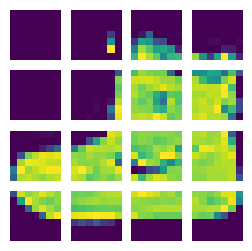

In [140]:
def reshape_tile(xs, tile=7):
    # xs: (batch, channel, height, width)
    batch, c, h, w = xs.shape
    assert h % tile == 0
    assert w % tile == 0
    assert c == 1
    xs = xs.view(batch, h // tile, tile, w // tile, tile)
    xs = xs.permute(0, 1, 3, 2, 4)
    xs = xs.contiguous().view(batch, -1, tile * tile)
    return xs

def plot_tiles(xs):
    _, d_tiles, tile = xs.shape
    h = w = int(tile ** 0.5)
    row = col = int(d_tiles ** 0.5)
    assert h * w == tile
    assert row * col == d_tiles
    xs = xs.reshape(d_tiles, h, w)
    fig, axs = plt.subplots(row, col, figsize=(3, 3))
    for i, x in enumerate(xs):
        ax = axs[i // row, i % col]
        ax.imshow(x.cpu().numpy())
        ax.axis('off')

plot_tiles(reshape_tile(trainset[0][0][None]))

In [ ]:
# train tiles
mnist_tiles = MNIST(7**2, hidden_size, 10).to(device)
train_mnist(mnist_tiles, trainloader, filename='mnist', epochs=20, reshape=reshape_tile)

### saliency map

In [167]:
def saliency(model, x, y, accumulate=1, noise=None, reshape=reshape_default):
    model.eval()
    x, y = x.to(device), y.to(device)
    x.requires_grad = True
    x.grad = None
    for _ in range(accumulate):
        xs = reshape(x)
        if noise is not None:
            noise = t.randn_like(xs) * noise
            xs = xs + noise
        out = model(xs)
        # loss = -out[0, y]
        loss = F.cross_entropy(out, y)
        loss.backward()
    model.train()
    return x.grad

### compare pixel attribution

In [136]:
comparison_epochs = 100
batch_size=6400
vocab_size=10
hidden_size=100
resolution=28

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.FashionMNIST('./fashion-mnist/', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('./fashion-mnist/', download=True, train=False, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

#### MLP

In [150]:
mlp = nn.Sequential(nn.Linear(28**2, d_hidden), nn.ReLU(), nn.Dropout(0.5), nn.Linear(d_hidden, 10)).to(device)
train_mnist(mlp, trainloader, filename='mnist', epochs=comparison_epochs, reshape=nn.Flatten())

  0%|          | 0/40 [00:00<?, ?it/s]

loss=1.2533 accuracy=0.6983999609947205


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▂▃▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
loss,█▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.8632
loss,0.3706


#### CNN

In [151]:
def noop(x): return x
cnn = nn.Sequential(nn.Conv2d(1, 8, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, stride=2),
                   nn.Conv2d(8, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, stride=2),
                   nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, stride=2),
                   nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(3, stride=3),
                   nn.Flatten(), nn.Dropout(0.5), nn.Linear(64, 10))

train_mnist(cnn, trainloader, filename='mnist', epochs=comparison_epochs, reshape=noop)

  0%|          | 0/40 [00:00<?, ?it/s]

loss=2.2207 accuracy=0.48259997367858887


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▁▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
loss,█▇▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.8408
loss,0.46428


#### RNN rows

In [152]:
class RNNrow(nn.Module):
    def __init__(self, d_in, d_hidden, d_out):
        super().__init__()
        self.emb = nn.Linear(d_in, d_hidden)
        self.rnn = RNN(d_hidden, d_hidden)
        self.dropout = nn.Dropout(0.5)
        self.head = nn.Linear(d_hidden, d_out)

    def forward(self, x):
        x = self.emb(x)
        x = self.rnn(x)[:, -1]
        x = self.dropout(x)
        return self.head(x)

rnn_rows = RNNrow(28, hidden_size, 10).to(device)
train_mnist(rnn_rows, trainloader, filename='mnist', epochs=comparison_epochs, reshape=reshape_default)

  0%|          | 0/40 [00:00<?, ?it/s]

loss=1.8976 accuracy=0.4032000005245209


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▂▃▃▄▄▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████████
loss,█▆▆▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.8125
loss,0.53578


#### GRU rows

In [153]:
class GRUrow(nn.Module):
    def __init__(self, d_in, d_hidden, d_out):
        super().__init__()
        self.gru = GRU(d_in, d_hidden)
        self.dropout = nn.Dropout(0.5)
        self.head = nn.Linear(d_hidden, d_out)

    def forward(self, x):
        x = self.gru(x)[:, -1]
        x = self.dropout(x)
        return self.head(x)

gru_rows = GRUrow(28, hidden_size, 10).to(device)
train_mnist(gru_rows, trainloader, filename='mnist', epochs=comparison_epochs, reshape=reshape_default)

  0%|          | 0/40 [00:00<?, ?it/s]

loss=2.0975 accuracy=0.3287000060081482


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▂▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇████████████████████
loss,█▇▆▅▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.8535
loss,0.41729


#### LSTM rows

In [154]:
lstm_rows = MNIST(28, hidden_size, 10).to(device)
train_mnist(lstm_rows, trainloader, filename='mnist', epochs=comparison_epochs, reshape=reshape_default)

  0%|          | 0/40 [00:00<?, ?it/s]

loss=2.1693 accuracy=0.2263999879360199


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇████████████████████████
loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.8665
loss,0.36951


#### LSTM tiles

In [155]:
lstm_tiles = MNIST(7**2, hidden_size, 10).to(device)
train_mnist(lstm_tiles, trainloader, filename='mnist', epochs=comparison_epochs, reshape=reshape_tile)

  0%|          | 0/40 [00:00<?, ?it/s]

loss=2.2158 accuracy=0.14190000295639038


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▃▄▄▅▆▆▇▇▇▇▇▇▇▇▇████████████████████████
loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.8326
loss,0.44083


#### save

In [158]:
# t.save({
#         'mlp': mlp.state_dict(),
#         'cnn': cnn.state_dict(),
#         'rnn_rows': rnn_rows.state_dict(),
#         'gru_rows': gru_rows.state_dict(),
#         'lstm_rows': lstm_rows.state_dict(),
#         'lstm_tiles': lstm_tiles.state_dict(),
#         }, 'weights/fashion-mnist-comparison.pt')

#### compare

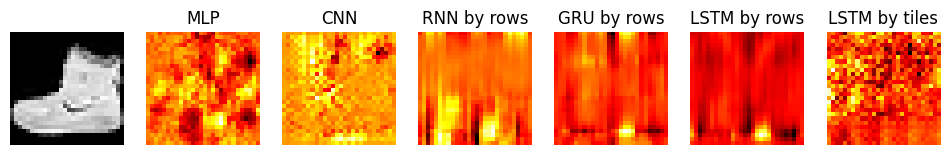

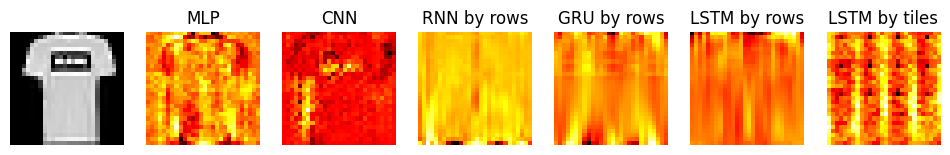

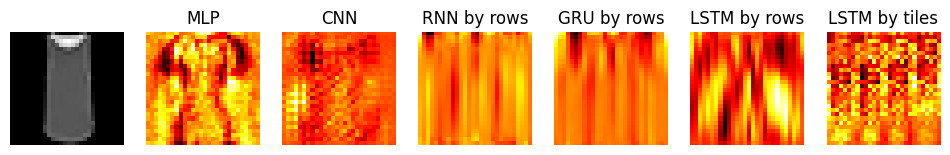

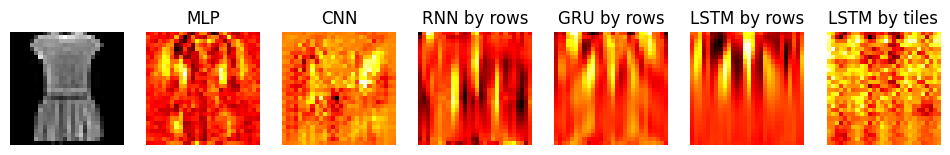

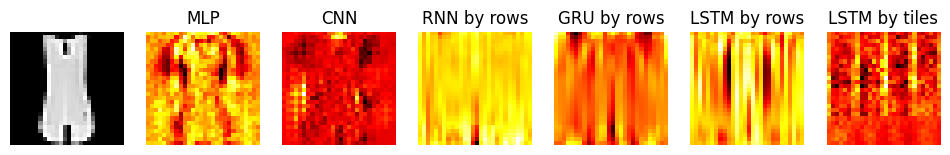

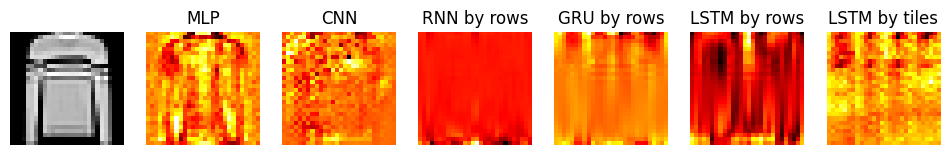

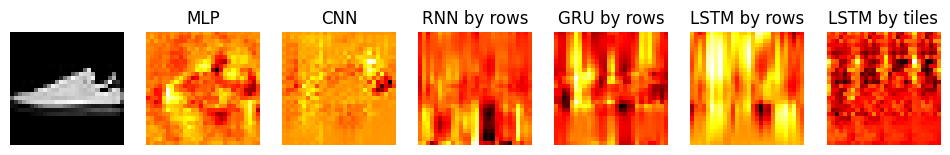

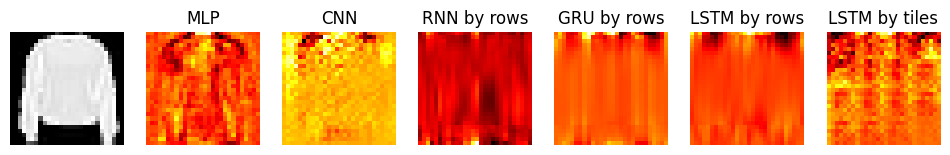

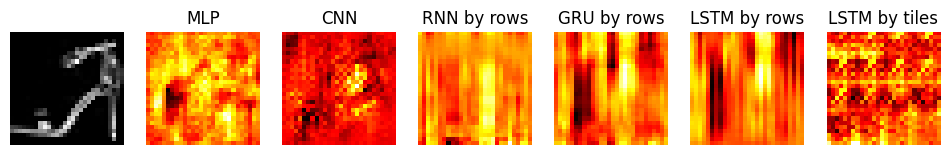

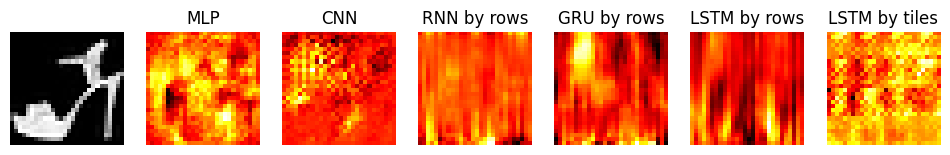

In [168]:
models = [('MLP', mlp, nn.Flatten()),
          ('CNN', cnn, noop),
          ('RNN by rows', rnn_rows, reshape_default),
          ('GRU by rows', gru_rows, reshape_default),
          ('LSTM by rows', lstm_rows, reshape_default),
          ('LSTM by tiles', lstm_tiles, reshape_tile),]
for n in range(10):
    xs, ys = trainset[n][0][None], t.tensor([trainset[n][1]])
    fig, axs = plt.subplots(1, len(models) + 1, figsize=(12, 4))
    axs[0].imshow(trainset[n][0][0], cmap='gray')
    axs[0].axis('off')
    for i, (name, model, reshape) in enumerate(models):
        grads = saliency(model, xs, ys, reshape=reshape)
        axs[i + 1].imshow(grads[0, 0].cpu().numpy(), cmap='hot')
        axs[i + 1].set_title(name)
        axs[i + 1].axis('off')
    plt.show()

### fashion MNIST

In [130]:
batch_size=6400
vocab_size=10
hidden_size=100
resolution=28

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.FashionMNIST('./fashion-mnist/', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('./fashion-mnist/', download=True, train=False, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)